# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the image file of dataset
images = np.load('/content/drive/My Drive/CNN/Project/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/My Drive/CNN/Project/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [4]:
print(images.shape)  ## Shape of the images
print(labels.shape)  ## Shape of the labels

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128X128X3, each image with 3 channels

## Exploratory Data Analysis

### Plotting random images from each of the class

In [5]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

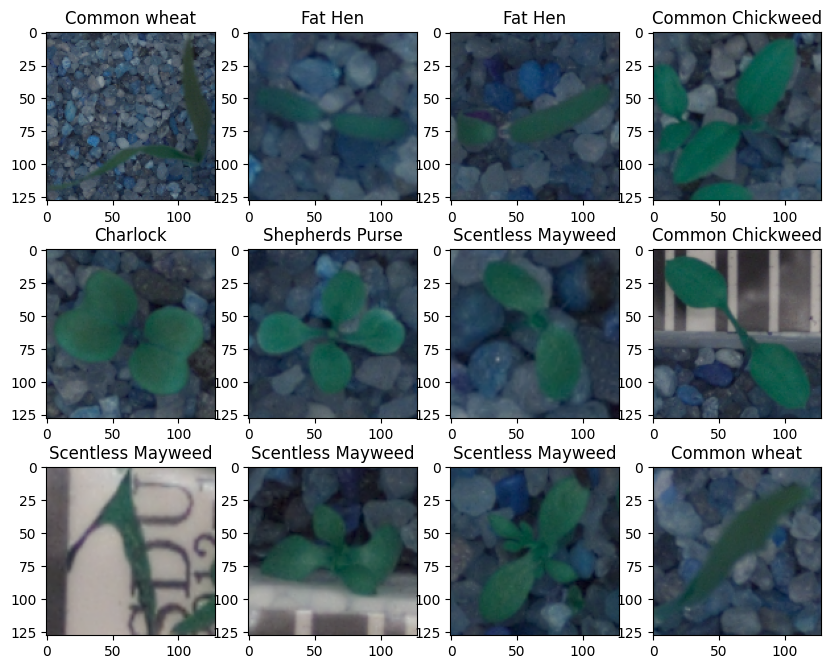

In [6]:
plot_images(images,labels)   # input the images and labels to the function and plot the images with their labels

In [7]:
labels

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


### Checking the distribution of the target variable

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

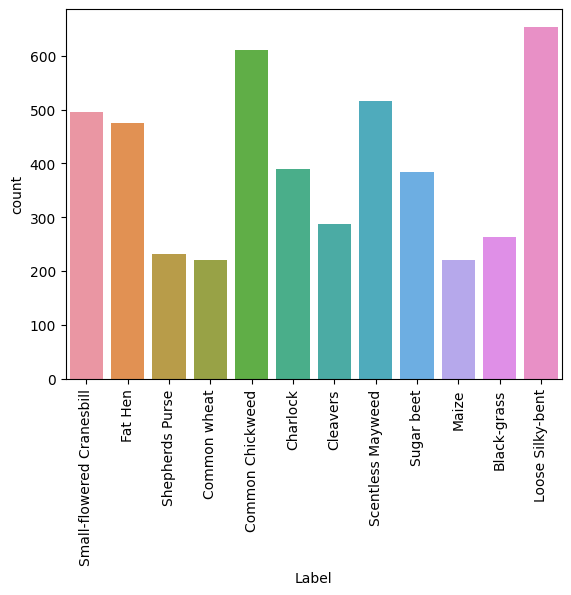

In [8]:
sns.countplot(x=labels['Label'])            # check for data imbalance
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [9]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)        # convert the images from BGR to RGB

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [10]:
images_decreased=[]
height = 64                   # define the height as 64
width =  64                   # define the width as 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

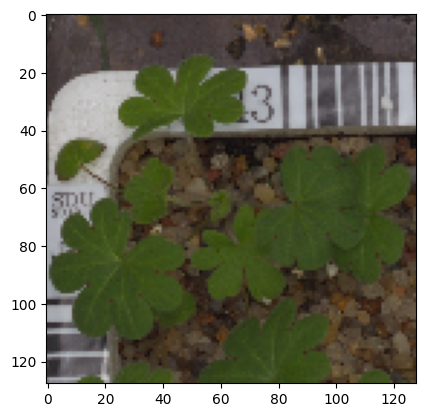

In [11]:
plt.imshow(images[3])

**Image after resizing**

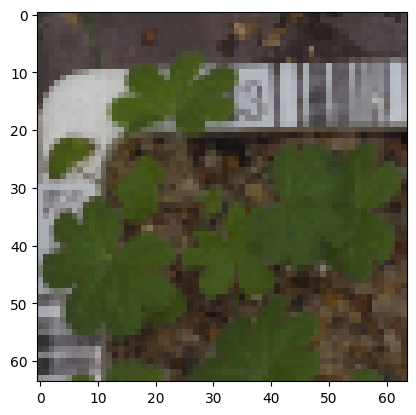

In [12]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [13]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)   # split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42,stratify=y_temp)                       # split the data with test_size as 0.1

In [14]:
# check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encoding the target labels

In [15]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()                              # intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        # fit and transform y_train
y_val_encoded=enc.transform(y_val)                  # transform y_val
y_test_encoded=enc.transform(y_test)                # transform y_test

In [16]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    # check the shape of train, validation and test data

((3847, 12), (428, 12), (475, 12))

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [17]:
# normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [18]:
# Clearing backend
backend.clear_session()

In [19]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [20]:
# Intializing a sequential model
model1 = Sequential()                             # intialize a sequential model

# add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Use the Adam Optimizer
opt=Adam()
# Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

<b> Fitting the model on the train data

In [21]:
# fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4543 - accuracy: 0.1081 - val_loss: 2.4359 - val_accuracy: 0.1425 - 13s/epoch - 108ms/step
Epoch 2/30
121/121 - 2s - loss: 2.3416 - accuracy: 0.2038 - val_loss: 2.1033 - val_accuracy: 0.3762 - 2s/epoch - 15ms/step
Epoch 3/30
121/121 - 2s - loss: 2.0717 - accuracy: 0.3023 - val_loss: 1.8404 - val_accuracy: 0.4019 - 2s/epoch - 18ms/step
Epoch 4/30
121/121 - 2s - loss: 1.9173 - accuracy: 0.3413 - val_loss: 1.7274 - val_accuracy: 0.4182 - 2s/epoch - 16ms/step
Epoch 5/30
121/121 - 1s - loss: 1.7857 - accuracy: 0.3551 - val_loss: 1.6326 - val_accuracy: 0.4603 - 1s/epoch - 10ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7055 - accuracy: 0.3863 - val_loss: 1.4855 - val_accuracy: 0.5023 - 1s/epoch - 10ms/step
Epoch 7/30
121/121 - 1s - loss: 1.6337 - accuracy: 0.3964 - val_loss: 1.3414 - val_accuracy: 0.5374 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.5894 - accuracy: 0.4060 - val_loss: 1.2701 - val_accuracy: 0.5327 - 1s/epoch - 9ms/step
Epoch 9/30
121/

**Model Evaluation**

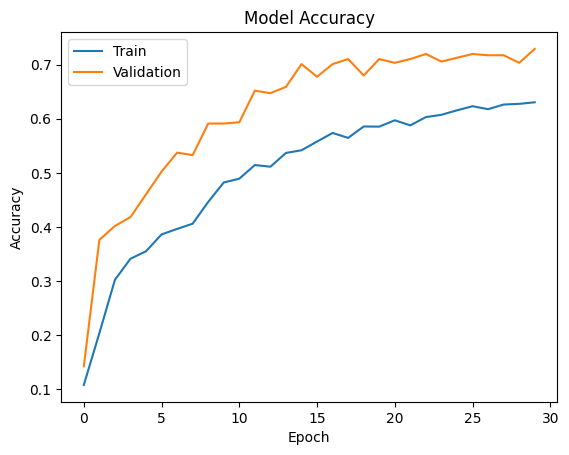

In [22]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- We can see from the above plot that training accuracy was good but validation
accuracy was not good

- Model seems to overfit on the data

**Evaluate the model on test data**

In [23]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    # evaluate the model on test data

15/15 - 0s - loss: 0.9537 - accuracy: 0.7179 - 201ms/epoch - 13ms/step


**Plotting the Confusion Matrix**

In [24]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # predict the output probabilities

15/15 [==============================] - 0s 3ms/step


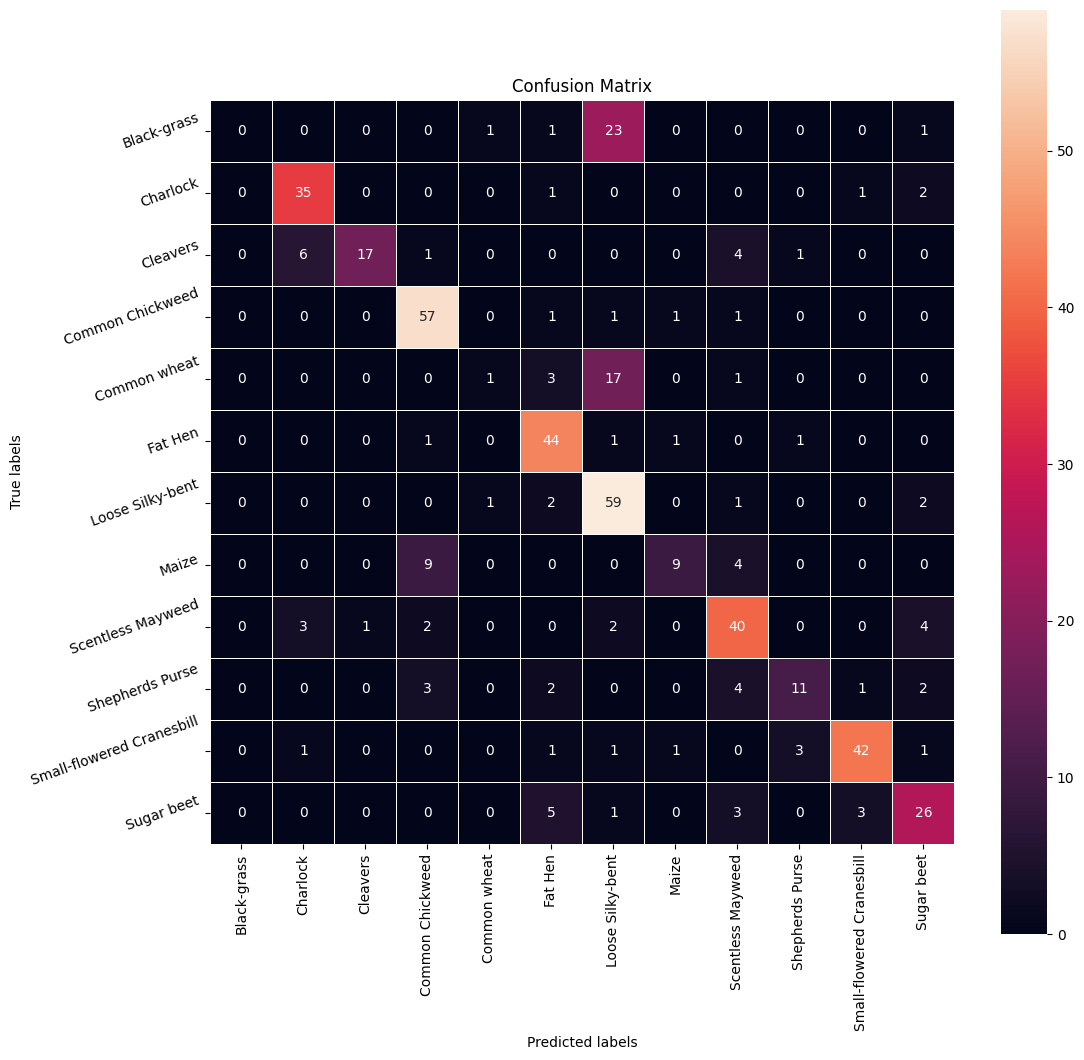

In [25]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

Observations

- We observe that some of the classes are not predicted correctly

- Some species like Loose Silky-bent, Common Chickweed, Shepherds Purse are well classified when compared to other species

- Some species like Shepherds Purse, Scentless Mayweed, Maize are mostly misclassified

**Plotting Classification Report**

In [26]:
# Plotting the classification report
from sklearn.metrics import classification_report
cr=classification_report(y_test_arg,y_pred_arg)     # plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.78      0.90      0.83        39
           2       0.94      0.59      0.72        29
           3       0.78      0.93      0.85        61
           4       0.33      0.05      0.08        22
           5       0.73      0.92      0.81        48
           6       0.56      0.91      0.69        65
           7       0.75      0.41      0.53        22
           8       0.69      0.77      0.73        52
           9       0.69      0.48      0.56        23
          10       0.89      0.84      0.87        50
          11       0.68      0.68      0.68        38

    accuracy                           0.72       475
   macro avg       0.65      0.62      0.61       475
weighted avg       0.68      0.72      0.68       475



## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [27]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Data Augmentation**

In [28]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [29]:
# set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [30]:
# Intializing a sequential model
model2 = Sequential()

# add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# Add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# initialize Adam Optimimzer
opt=Adam()
# code to Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

<b> Fitting the model on the train data

In [31]:
# fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 9s 112ms/step - loss: 2.1303 - accuracy: 0.2517 - val_loss: 2.4219 - val_accuracy: 0.1519 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 75ms/step - loss: 1.6566 - accuracy: 0.4179 - val_loss: 2.2829 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 4s 73ms/step - loss: 1.4581 - accuracy: 0.4819 - val_loss: 2.2146 - val_accuracy: 0.3061 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 6s 105ms/step - loss: 1.3612 - accuracy: 0.5229 - val_loss: 2.1113 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 80ms/step - loss: 1.2459 - accuracy: 0.5593 - val_loss: 1.7648 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 6s 95ms/step - loss: 1.1489 - accuracy: 0.5895 - val_loss: 1.6576 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 4s 73ms/step - loss: 1

**Model Evaluation**

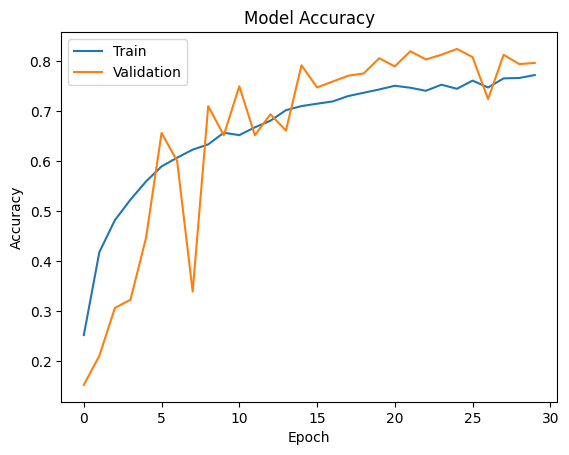

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [33]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Evaluate the model on test data

15/15 - 0s - loss: 0.8227 - accuracy: 0.7389 - 181ms/epoch - 12ms/step


We can observe that accuracy has improved compared to previous model

**Plotting the Confusion Matrix**

In [34]:
# Obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


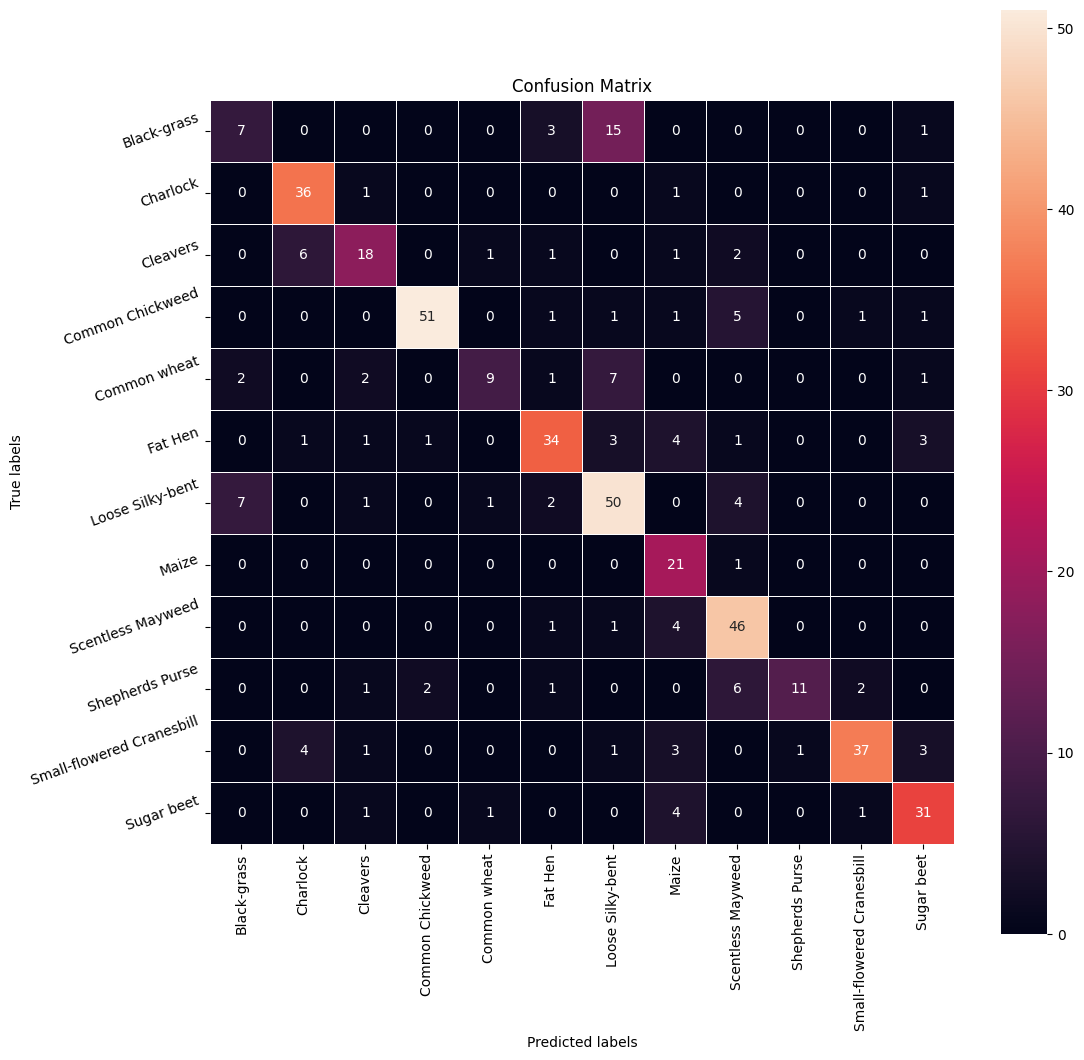

In [35]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

Confusion matrix seems to be improving when compared to previous model but there are still misclassfied classes

Loose Silky-bent class is the most confusing class

The model seems outperforming when compared to previous model

**Plotting Classification Report**

In [36]:
from sklearn.metrics import classification_report
# Plotting the classification report
cr=classification_report(y_test_arg,y_pred_arg)     # plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.44      0.27      0.33        26
           1       0.77      0.92      0.84        39
           2       0.69      0.62      0.65        29
           3       0.94      0.84      0.89        61
           4       0.75      0.41      0.53        22
           5       0.77      0.71      0.74        48
           6       0.64      0.77      0.70        65
           7       0.54      0.95      0.69        22
           8       0.71      0.88      0.79        52
           9       0.92      0.48      0.63        23
          10       0.90      0.74      0.81        50
          11       0.76      0.82      0.78        38

    accuracy                           0.74       475
   macro avg       0.74      0.70      0.70       475
weighted avg       0.75      0.74      0.73       475



## Final Model

- According to the confusion matrix and accuracy curve, the model2 with data augmentation has outperformed previous model.
- Thus we can say that model2 is our best model and we can use this model to predict and visualize some test images.

### Visualizing the prediction

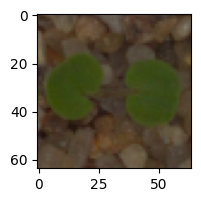

1/1 [==============================] - 0s 71ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


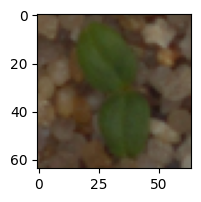

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Cleavers']
True Label Cleavers


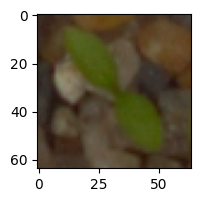

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


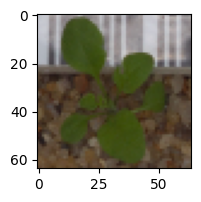

1/1 [==============================] - 0s 24ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [37]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

In [40]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation'],'Train Accuracy':['63.04%','77.2%'],'Validation Accuracy':['72.9%','79.6%,'],'Test Accuracy':['71.7','73.8']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,63.04%,72.9%,71.7
1,CNN Model with Data Augmentation,77.2%,"79.6%,",73.8


## Conclusion


- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

_____